# imported the libraries

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy, Precision, Recall, F1Score
from tqdm import tqdm
from torchmetrics.classification import BinaryConfusionMatrix
from torchvision.models import ResNet18_Weights
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os  

In [41]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# model.to(device)

In [42]:
import torch
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed value
set_seed(42)

## reading the dataset

In [43]:
# Define the paths to the dataset
dataset_path = '../Annotations'
images_path = "../Pain_Dataset_Images"
frame_labels_path = os.path.join(dataset_path, 'Frame_Labels')
sequence_labels_path = os.path.join(dataset_path, 'Sequence_Labels')

In [44]:
def compute_pain_score(facs_path):
    au_intensities = {}
    try:
        with open(facs_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            au = int(float(parts[0]))
            intensity = float(parts[1])
            au_intensities[au] = intensity
    except Exception as e:
        print(f"Error reading {facs_path}: {e}")
        return 0  # Default pain score in case of error
    
    # Calculate pain score based on AU intensities
    # Pain = AU4 + (AU6 or AU7) + (AU9 or AU10) + AU43
    pain_score = 0
    if 4 in au_intensities:
        pain_score += au_intensities[4]
    pain_score += max(au_intensities.get(6, 0), au_intensities.get(7, 0))
    pain_score += max(au_intensities.get(9, 0), au_intensities.get(10, 0))
    if 43 in au_intensities:
        pain_score += 1
    
    return pain_score

In [45]:
# Define a function to read frame-level FACS codes and compute pain scores
def load_frame_pain_scores(frame_labels_path):
    pain_scores = []
    for root, dirs, files in os.walk(os.path.join(frame_labels_path, 'FACS')):
        for file in files:
            if file.endswith('_facs.txt'):
                filepath = os.path.join(root, file)
                pain_score = compute_pain_score(filepath)
                pain_scores.append((file.replace('_facs.txt', ''), pain_score))
    return pd.DataFrame(pain_scores, columns=['Filename', 'Pain Intensity'])

# Load frame-level data
frame_pain_scores = load_frame_pain_scores(frame_labels_path)


<Axes: title={'center': 'Distribution of PSPI Scores'}, xlabel='Pain Intensity'>

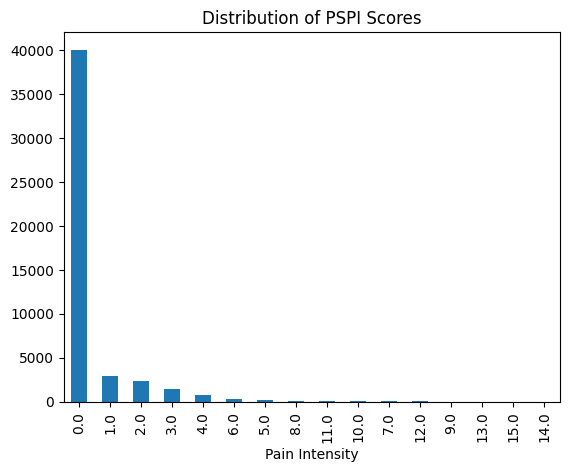

In [46]:
frame_pain_scores["Pain Intensity"].value_counts().plot(kind='bar', title='Distribution of PSPI Scores')

In [47]:
# Define the bins and labels
bins = [-1, 0, 2, 4, 6, 8, 10, 12, 14, 16]
labels = ['0', '1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15-16']

# Categorize the pain intensity into bins
frame_pain_scores['PSPI Score'] = pd.cut(frame_pain_scores['Pain Intensity'], bins=bins, labels=labels)

<Axes: title={'center': 'Distribution of PSPI Scores Binned'}, xlabel='PSPI Score'>

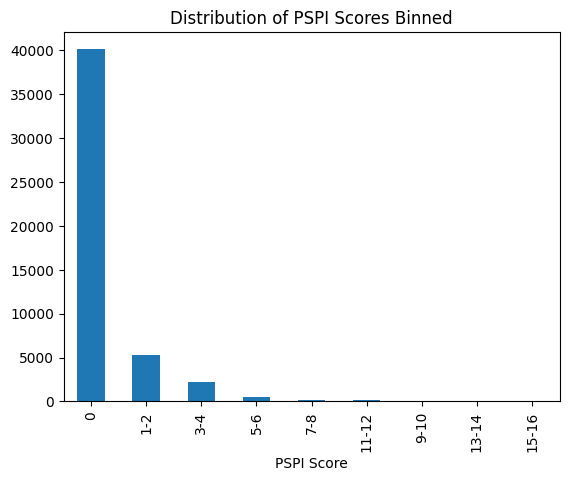

In [48]:
frame_pain_scores['PSPI Score'].value_counts().plot(kind='bar', title='Distribution of PSPI Scores Binned')

In [49]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_images_and_scores(images_path, frame_pain_scores):
    """
    Load images and corresponding pain scores from the given directory and DataFrame.

    Args:
        images_path (str): Path to the directory containing the images.
        frame_pain_scores (pandas.DataFrame): DataFrame containing the pain scores.

    Returns:
        images (numpy.ndarray): Array of loaded images.
        image_path_list (list): List of image paths.
        scores (numpy.ndarray): Array of corresponding pain scores.
    """
    images = []
    scores = []
    image_path_list = []
    for idx, row in tqdm(frame_pain_scores.iterrows(), total=len(frame_pain_scores)):

        subject_id = row['Filename'][2:5] 
        full_id = row['Filename'][:5] 
        sequence_id = row['Filename'][:-3]
        image_filename = row['Filename'] + '.png'

        img_path = os.path.join(images_path, f"{subject_id}-{full_id}", sequence_id, image_filename)
        
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        image_path_list.append(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append(img)
            scores.append(row['Pain Intensity'])
    
    images = np.array(images)
    scores = np.array(scores)
    
    return images, image_path_list, scores


images_path = 'Pain_Dataset_Images'
images, image_path_list, scores = load_images_and_scores(images_path, frame_pain_scores)
print(f"Loaded {len(images)} images and {len(scores)} scores.")

100%|██████████| 48398/48398 [02:01<00:00, 398.63it/s]


Loaded 48398 images and 48398 scores.


In [50]:
# create a dataframe
df = pd.DataFrame()
df['image_path'] = image_path_list
df['Pain Intensity'] = scores
df['Pain Label'] = df['Pain Intensity'].apply(lambda x: 'pain' if x > 0 else 'no pain')
df.to_csv('pain_dataset_label.csv', index=False)

<Axes: title={'center': 'Distribution of Pain / No Pain Labels'}, xlabel='Pain Label'>

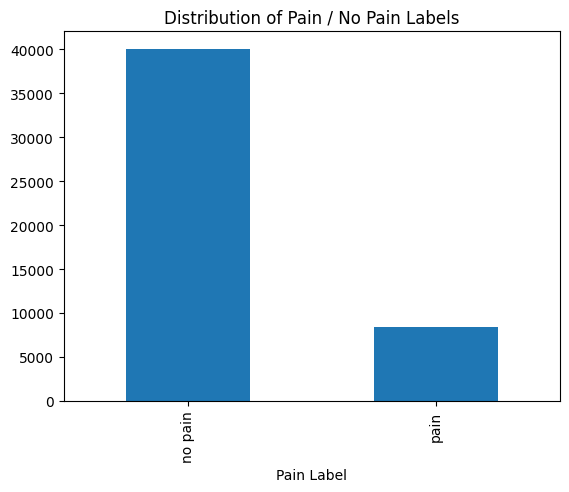

In [51]:
df['Pain Label'].value_counts().plot(kind='bar', title='Distribution of Pain / No Pain Labels')

In [5]:
# image_path = "Pain_Dataset_Images"

In [52]:
label_df = pd.read_csv('pain_dataset_label.csv')

In [53]:
label_df.head()

,image_path,Pain Intensity,Pain Label
0,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak0...,0.0,no pain
1,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak0...,0.0,no pain
2,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak0...,0.0,no pain
3,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak0...,0.0,no pain
4,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak0...,0.0,no pain


In [7]:
label_df['Pain Intensity'].value_counts()

Pain Intensity
0.0     40029
1.0      2909
2.0      2351
3.0      1412
4.0       802
6.0       270
5.0       242
8.0        79
11.0       76
10.0       67
7.0        53
12.0       48
9.0        32
13.0       22
15.0        5
14.0        1
Name: count, dtype: int64

In [54]:
label_df['Pain Label'].value_counts()

Pain Label
no pain    40029
pain        8369
Name: count, dtype: int64

In [55]:
label_df['Pain Label'] = label_df['Pain Label'].map({'pain': 1, 'no pain': 0})

In [56]:
label_df['Pain Label'].value_counts()

Pain Label
0    40029
1     8369
Name: count, dtype: int64

## Split the dataset to train, valid, test

In [58]:
label_df['subject_id'] =  label_df['image_path'].str.split('/').str[1]
label_df['sequence_id'] = label_df['image_path'].str.split('/').str[2]
label_df['sequence_no'] =  label_df['image_path'].str.split('/').str[3].str[-7:-4]

In [59]:
all_individual = label_df['image_path'].str.split("/").str[1].value_counts().index.tolist()

# this individual has only 0 as pain intensity, which was biasing out model so removed it.
all_individual = label_df['subject_id'].unique().tolist()
all_individual = [i for i in all_individual if i != "101-mg101"]
len(all_individual)


print("Total number of individuals:", len(all_individual))

train_list, val_list = train_test_split(all_individual, test_size=0.20, random_state=42)
val_list, test_list = train_test_split(val_list, test_size=0.20, random_state=42)

print("Number of individuals in the training set:", len(train_list))
print("Number of individuals in the validation set:", len(val_list))
print("Number of individuals in the test set:", len(test_list))

# make the traininig and validation df based on the individual
train_df = pd.concat([label_df[label_df['subject_id'] == individual].reset_index(drop=True) 
                      for individual in train_list], axis=0).reset_index(drop=True)

val_df = pd.concat([label_df[label_df['subject_id'] == individual ].reset_index(drop=True)
                    for individual in val_list], axis=0).reset_index(drop=True)

test_df = pd.concat([label_df[label_df['subject_id'] == individual].reset_index(drop=True)
                        for individual in test_list], axis=0).reset_index(drop=True)
print(train_df.shape, val_df.shape, test_df.shape)

Total number of individuals: 24
Number of individuals in the training set: 19
Number of individuals in the validation set: 4
Number of individuals in the test set: 1
(34541, 6) (8130, 6) (2908, 6)


### Undersampling

In [60]:
# Undersample the dataset for only training

min_count = train_df['Pain Label'].value_counts().min()

pain_df = train_df[train_df['Pain Label'] == 1].sample(n=min_count, random_state=42)
no_pain_df = train_df[train_df['Pain Label'] == 0].sample(n=min_count, random_state=42)

sample_df = pd.concat([pain_df, no_pain_df], axis=0).reset_index(drop=True)
print(sample_df.shape)

(12744, 6)


In [61]:
sample_df['Pain Label'].value_counts()

Pain Label
1    6372
0    6372
Name: count, dtype: int64

In [21]:
num_classes = 1
num_classes

1

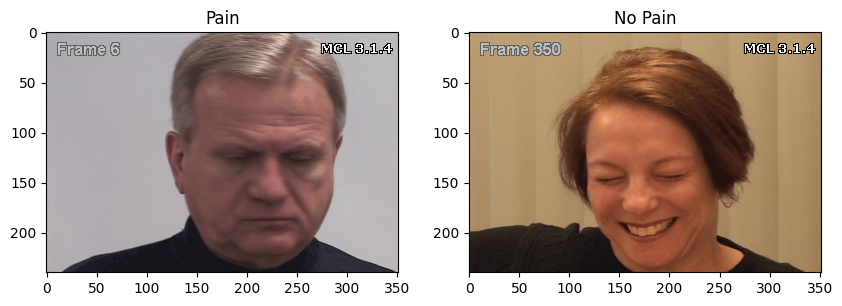

In [63]:
# Filter the dataset for 'Pain' and 'No Pain' labels
pain_image_path = label_df[label_df['Pain Label'] == 0].sample(1)['image_path'].iloc[0]
no_pain_image_path = label_df[label_df['Pain Label'] == 1].sample(1)['image_path'].iloc[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

pain_image = Image.open(pain_image_path)
ax[0].imshow(pain_image)
ax[0].set_title('Pain')

no_pain_image = Image.open(no_pain_image_path)
ax[1].imshow(no_pain_image)
ax[1].set_title('No Pain')

plt.show()

## Model Training

In [71]:
class PainDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(image_path).convert('RGB')
        pain_intensity = self.dataframe.iloc[idx]['Pain Label']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(pain_intensity, dtype=torch.float)

In [72]:
import torchvision.transforms as transforms

# Define transforms for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate the image by up to 15 degrees
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use a simpler transform for validation (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = PainDataset(sample_df, transform=train_transform)
val_dataset = PainDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [65]:
num_classes = 1


# Load pre-trained ResNet18 model
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)


# from torchvision.models import ResNeXt50_32X4D_Weights

# # load pretrained model of resnexr50
# model = models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)

# Modify the final layer for the number of classes in your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

In [25]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, monitor='f1-score', path='checkpoint.pt'):
        self.patience = patience
        self.monitor = monitor
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, monitor, model):
        if self.best_score is None:
            self.best_score = monitor
            self.save_checkpoint(model)
        elif monitor < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = monitor
            self.counter = 0
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        '''Saves the model when the monitored metric improves.'''
        torch.save(model.state_dict(), self.path)
        print(f'Model saved to {self.path}')

In [74]:
model.to(device)
criterion_intensity = nn.BCEWithLogitsLoss()

In [27]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

def train(model, loader, optimizer, criterion_intensity, device):
    model.train()
    running_loss = 0.0
    accuracy = Accuracy(task='binary',num_classes = num_classes).to(device)
    precision = Precision(task='binary', num_classes = num_classes).to(device)
    recall = Recall(task='binary', num_classes = num_classes).to(device)
    f1 = F1Score(task='binary', num_classes = num_classes).to(device)

    for images, pain_intensity in tqdm(loader):
        images, pain_intensity = images.to(device), pain_intensity.to(device)

        optimizer.zero_grad()

        outputs_intensity = model(images).squeeze()

        loss_intensity = criterion_intensity(outputs_intensity, pain_intensity)

        loss = loss_intensity
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
      
        preds = (torch.sigmoid(outputs_intensity) > 0.5).int()
     
        accuracy.update(preds, pain_intensity.int())
        precision.update(preds, pain_intensity.int())
        recall.update(preds, pain_intensity.int())
        f1.update(preds, pain_intensity.int())

    avg_loss = running_loss / len(loader)
    acc = accuracy.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    f1_score = f1.compute().item()

    # Reset metrics for the next epoch
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

    return avg_loss, acc, prec, rec, f1_score

In [68]:
def validate(model, loader, criterion_intensity, device, confusion_matrix_=False):
    model.eval()
    running_loss = 0.0
    accuracy = Accuracy(task='binary', num_classes = num_classes).to(device)
    precision = Precision(task='binary', num_classes = num_classes).to(device)
    recall = Recall(task='binary', num_classes = num_classes).to(device)
    f1 = F1Score(task='binary', num_classes = num_classes).to(device)
    
    output_list = []
    target_list = []

    with torch.no_grad():
        for images, pain_intensity in loader:
            images, pain_intensity = images.to(device), pain_intensity.to(device)

            outputs_intensity = model(images).squeeze()

            loss_intensity = criterion_intensity(outputs_intensity, pain_intensity)

            running_loss += loss_intensity.item()

            # Convert logits to binary predictions with 0 or 1 based on a threshold of 0.5
            preds = (torch.sigmoid(outputs_intensity) > 0.5).int()


            output_list.extend(preds.cpu().numpy())
            target_list.extend(pain_intensity.cpu().numpy())
            

            accuracy.update(preds, pain_intensity.int())
            precision.update(preds, pain_intensity.int())
            recall.update(preds, pain_intensity.int())
            f1.update(preds, pain_intensity.int())

    avg_loss = running_loss / len(loader)
    acc = accuracy.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    f1_score = f1.compute().item()

    # Reset metrics for the next epoch
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

    if confusion_matrix_:
        bcm = BinaryConfusionMatrix().to(device)
        output_list = torch.tensor(output_list).to(device)
        target_list = torch.tensor(target_list).to(device)
        confusion_matrix_score = bcm((output_list), (target_list))
        return avg_loss, acc, prec, rec, f1_score, confusion_matrix_score
    return avg_loss, acc, prec, rec, f1_score

In [29]:
# Training loop
num_epochs = 50

patience = 10
early_stopping = EarlyStopping(patience=patience, delta=0, monitor='val_f1_score', path='best_model_pain_1.pt')

start_time = 0
end_time = 0
training_losses = []
validation_losses = []

training_accuracies = []
validation_accuracies = []

training_f1_scores = []
validation_f1_scores = []

training_precisions = []
validation_precisions = []

for epoch in range(num_epochs):
    print('epoch starts:', epoch)
    start_time = time.time()
    train_loss, train_acc, train_prec, train_rec, train_f1_score = train(model, train_loader, optimizer, criterion_intensity, device)
    val_loss, val_acc, val_prec, val_rec, val_f1_score = validate(model, val_loader, criterion_intensity, device)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    training_f1_scores.append(train_f1_score)
    validation_f1_scores.append(val_f1_score)

    training_precisions.append(train_prec)
    validation_precisions.append(val_prec)

    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train Prec: {train_prec:.4f} | Train Rec: {train_rec:.4f} | Train F1: {train_f1_score:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Prec: {val_prec:.4f} | Val Rec: {val_rec:.4f} | Val F1: {val_f1_score:.4f}")

    early_stopping(val_f1_score, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break   
    end_time = time.time()
    print('time taken for epoch:', (end_time-start_time)/60, 'minutes')


epoch starts: 0


100%|██████████| 200/200 [02:23<00:00,  1.40it/s]


Epoch 1/50
Train Loss: 0.3656 | Train Acc: 0.8439 | Train Prec: 0.8319 | Train Rec: 0.8621 | Train F1: 0.8467
Val Loss: 0.5289 | Val Acc: 0.7391 | Val Prec: 0.4117 | Val Rec: 0.8748 | Val F1: 0.5599
Model saved to best_model_pain_1.pt
time taken for epoch: 3.054688286781311 minutes
epoch starts: 1


100%|██████████| 200/200 [02:24<00:00,  1.38it/s]


Epoch 2/50
Train Loss: 0.2348 | Train Acc: 0.9046 | Train Prec: 0.8959 | Train Rec: 0.9156 | Train F1: 0.9056
Val Loss: 0.5194 | Val Acc: 0.7480 | Val Prec: 0.4038 | Val Rec: 0.6900 | Val F1: 0.5095
EarlyStopping counter: 1 out of 5
time taken for epoch: 3.1082796335220335 minutes
epoch starts: 2


100%|██████████| 200/200 [02:27<00:00,  1.35it/s]


Epoch 3/50
Train Loss: 0.1938 | Train Acc: 0.9233 | Train Prec: 0.9217 | Train Rec: 0.9253 | Train F1: 0.9235
Val Loss: 0.3343 | Val Acc: 0.8379 | Val Prec: 0.5837 | Val Rec: 0.5065 | Val F1: 0.5424
EarlyStopping counter: 2 out of 5
time taken for epoch: 3.1755409320195516 minutes
epoch starts: 3


100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Epoch 4/50
Train Loss: 0.1659 | Train Acc: 0.9374 | Train Prec: 0.9355 | Train Rec: 0.9396 | Train F1: 0.9375
Val Loss: 0.6450 | Val Acc: 0.7185 | Val Prec: 0.3913 | Val Rec: 0.8722 | Val F1: 0.5403
EarlyStopping counter: 3 out of 5
time taken for epoch: 3.221222400665283 minutes
epoch starts: 4


100%|██████████| 200/200 [02:25<00:00,  1.38it/s]


Epoch 5/50
Train Loss: 0.1540 | Train Acc: 0.9375 | Train Prec: 0.9351 | Train Rec: 0.9402 | Train F1: 0.9376
Val Loss: 0.3760 | Val Acc: 0.8189 | Val Prec: 0.5184 | Val Rec: 0.6388 | Val F1: 0.5723
Model saved to best_model_pain_1.pt
time taken for epoch: 3.112242384751638 minutes
epoch starts: 5


100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Epoch 6/50
Train Loss: 0.1527 | Train Acc: 0.9408 | Train Prec: 0.9388 | Train Rec: 0.9430 | Train F1: 0.9409
Val Loss: 0.5027 | Val Acc: 0.7993 | Val Prec: 0.4742 | Val Rec: 0.5357 | Val F1: 0.5030
EarlyStopping counter: 1 out of 5
time taken for epoch: 3.1721380154291787 minutes
epoch starts: 6


100%|██████████| 200/200 [02:27<00:00,  1.35it/s]


Epoch 7/50
Train Loss: 0.1373 | Train Acc: 0.9457 | Train Prec: 0.9463 | Train Rec: 0.9451 | Train F1: 0.9457
Val Loss: 0.3194 | Val Acc: 0.8606 | Val Prec: 0.6460 | Val Rec: 0.5869 | Val F1: 0.6150
Model saved to best_model_pain_1.pt
time taken for epoch: 3.20319641828537 minutes
epoch starts: 7


100%|██████████| 200/200 [02:27<00:00,  1.35it/s]


Epoch 8/50
Train Loss: 0.1274 | Train Acc: 0.9509 | Train Prec: 0.9495 | Train Rec: 0.9524 | Train F1: 0.9510
Val Loss: 0.3878 | Val Acc: 0.8262 | Val Prec: 0.5286 | Val Rec: 0.7724 | Val F1: 0.6277
Model saved to best_model_pain_1.pt
time taken for epoch: 3.179775762557983 minutes
epoch starts: 8


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch 9/50
Train Loss: 0.1152 | Train Acc: 0.9550 | Train Prec: 0.9535 | Train Rec: 0.9567 | Train F1: 0.9551
Val Loss: 0.4760 | Val Acc: 0.8250 | Val Prec: 0.5342 | Val Rec: 0.6025 | Val F1: 0.5663
EarlyStopping counter: 1 out of 5
time taken for epoch: 4.0277321656545 minutes
epoch starts: 9


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 10/50
Train Loss: 0.1306 | Train Acc: 0.9499 | Train Prec: 0.9460 | Train Rec: 0.9543 | Train F1: 0.9502
Val Loss: 0.3261 | Val Acc: 0.8518 | Val Prec: 0.6164 | Val Rec: 0.5785 | Val F1: 0.5969
EarlyStopping counter: 2 out of 5
time taken for epoch: 4.165285150210063 minutes
epoch starts: 10


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch 11/50
Train Loss: 0.1137 | Train Acc: 0.9557 | Train Prec: 0.9535 | Train Rec: 0.9581 | Train F1: 0.9558
Val Loss: 0.4560 | Val Acc: 0.8170 | Val Prec: 0.5110 | Val Rec: 0.8165 | Val F1: 0.6286
Model saved to best_model_pain_1.pt
time taken for epoch: 4.170617397626241 minutes
epoch starts: 11


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch 12/50
Train Loss: 0.0951 | Train Acc: 0.9656 | Train Prec: 0.9640 | Train Rec: 0.9674 | Train F1: 0.9657
Val Loss: 0.6378 | Val Acc: 0.7887 | Val Prec: 0.4698 | Val Rec: 0.8872 | Val F1: 0.6143
EarlyStopping counter: 1 out of 5
time taken for epoch: 4.137058130900065 minutes
epoch starts: 12


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch 13/50
Train Loss: 0.1028 | Train Acc: 0.9574 | Train Prec: 0.9552 | Train Rec: 0.9598 | Train F1: 0.9575
Val Loss: 0.5431 | Val Acc: 0.7343 | Val Prec: 0.3696 | Val Rec: 0.5681 | Val F1: 0.4479
EarlyStopping counter: 2 out of 5
time taken for epoch: 4.1536868135134375 minutes
epoch starts: 13


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch 14/50
Train Loss: 0.1033 | Train Acc: 0.9603 | Train Prec: 0.9583 | Train Rec: 0.9625 | Train F1: 0.9604
Val Loss: 0.5579 | Val Acc: 0.8025 | Val Prec: 0.4693 | Val Rec: 0.3178 | Val F1: 0.3790
EarlyStopping counter: 3 out of 5
time taken for epoch: 4.12601326306661 minutes
epoch starts: 14


100%|██████████| 200/200 [03:15<00:00,  1.03it/s]


Epoch 15/50
Train Loss: 0.1076 | Train Acc: 0.9581 | Train Prec: 0.9562 | Train Rec: 0.9601 | Train F1: 0.9582
Val Loss: 0.4135 | Val Acc: 0.8268 | Val Prec: 0.5519 | Val Rec: 0.4617 | Val F1: 0.5028
EarlyStopping counter: 4 out of 5
time taken for epoch: 4.0915237466494245 minutes
epoch starts: 15


100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


Epoch 16/50
Train Loss: 0.0897 | Train Acc: 0.9634 | Train Prec: 0.9613 | Train Rec: 0.9658 | Train F1: 0.9635
Val Loss: 0.5572 | Val Acc: 0.7613 | Val Prec: 0.4045 | Val Rec: 0.5480 | Val F1: 0.4654
EarlyStopping counter: 5 out of 5
Early stopping


## Evaluation

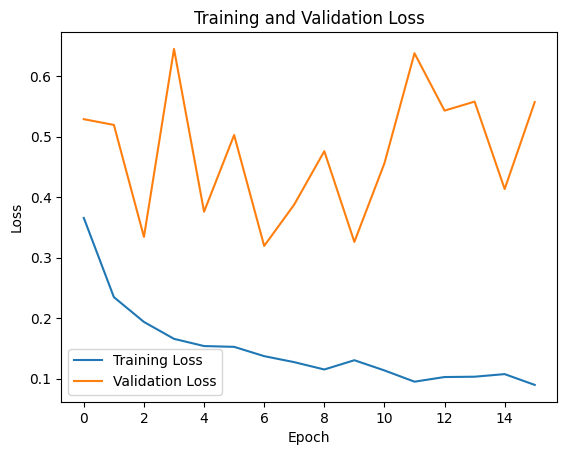

In [30]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

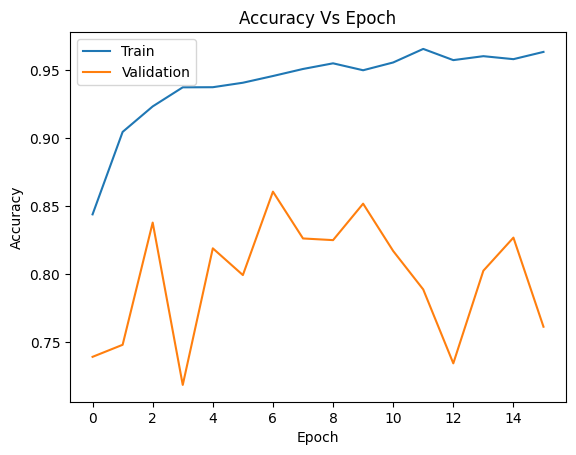

In [31]:
plt.plot(training_accuracies, label='Train')
plt.plot(validation_accuracies, label='Validation')
plt.title('Accuracy Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

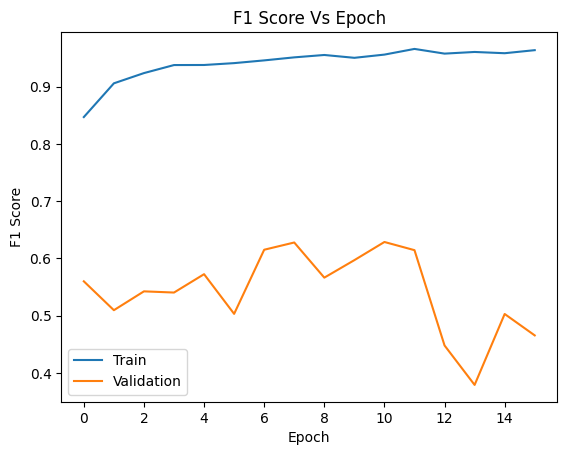

In [32]:
# plot f1 score for training and validation
plt.plot(training_f1_scores, label='Train')
plt.plot(validation_f1_scores, label='Validation')
plt.title('F1 Score Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

### Evaluation on validation set

In [66]:
# Load pre-trained ResNet18 model
best_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the final layer for the number of classes in your dataset
num_features = best_model.fc.in_features
best_model.fc = nn.Linear(num_features, num_classes) 

best_model.to(device)
best_model.load_state_dict(torch.load('best_model_pain_1.pt'))

/var/folders/jg/sz0fr37166zb_s69987d9z280000gn/T/ipykernel_66051/1539944344.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_m

<All keys matched successfully>

In [75]:
# final evaluation
val_loss, val_acc, val_prec, val_rec, val_f1_score, cf = validate(best_model, val_loader, 
                                                              criterion_intensity, 
                                                              device, confusion_matrix_=True)
print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f} | Validation Prec: {val_prec:.4f} | Validation Rec: {val_rec:.4f} | Validation F1: {val_f1_score:.4f}")

Validation Loss: 0.4560 | Validation Acc: 0.8170 | Validation Prec: 0.5110 | Validation Rec: 0.8165 | Validation F1: 0.6286


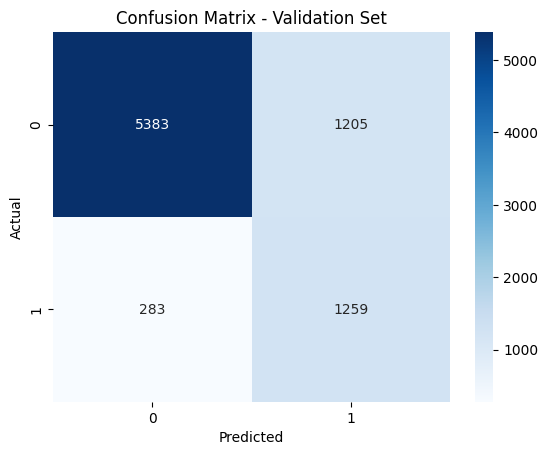

In [76]:
class_dict = {0: 'No Pain', 1: 'Pain'}
class_names = list(class_dict.keys())
cf_matrix = cf.cpu().numpy()

sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')
plt.show()

## Prediction on single image

In [36]:
# get random row in df
random_row = test_df.sample()
random_row

,image_path,Pain Intensity,Pain Label,subject_id,sequence_id,sequence_no
969,Pain_Dataset_Images/108-th108/th108t1afunaff/t...,0.0,0,108-th108,th108t1afunaff,101


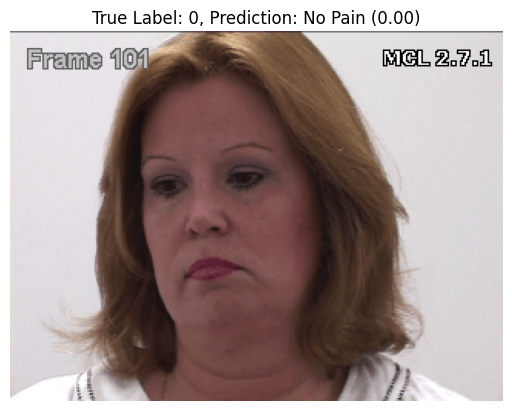

In [37]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_single_image(model, image_path, device):
    model.eval()
    
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Preprocess the image
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_batch).squeeze()
        prediction = torch.sigmoid(output).item()
    
    return prediction

def show_image_with_prediction(image_path, true_label, probability):
    image = Image.open(image_path)
    prediction_label = "Pain" if probability > 0.5 else "No Pain"
    plt.imshow(image)
    plt.title(f'True Label: {true_label}, Prediction: {prediction_label} ({probability:.2f})')
    plt.axis('off')
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

image_path = random_row['image_path'].values[0]
true_label = random_row['Pain Label'].values[0]

prediction = predict_single_image(best_model, image_path, device)
show_image_with_prediction(image_path, true_label, prediction)


### Inference of testset

In [38]:
test_df.head()

,image_path,Pain Intensity,Pain Label,subject_id,sequence_id,sequence_no
0,Pain_Dataset_Images/108-th108/th108t2aeaff/th1...,0.0,0,108-th108,th108t2aeaff,130
1,Pain_Dataset_Images/108-th108/th108t2aeaff/th1...,0.0,0,108-th108,th108t2aeaff,131
2,Pain_Dataset_Images/108-th108/th108t2aeaff/th1...,0.0,0,108-th108,th108t2aeaff,038
3,Pain_Dataset_Images/108-th108/th108t2aeaff/th1...,0.0,0,108-th108,th108t2aeaff,039
4,Pain_Dataset_Images/108-th108/th108t2aeaff/th1...,0.0,0,108-th108,th108t2aeaff,179


In [39]:
test_df.shape

(2908, 6)

In [40]:
# Running on Test set
test_dataset = PainDataset(test_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [41]:
# final evaluation
test_loss, test_acc, test_prec, test_rec, test_f1_score, cf = validate(best_model, test_loader, 
                                                              criterion_intensity, 
                                                              device, confusion_matrix_=True)
print(f"Testing Loss: {test_loss:.4f} | Testing Acc: {test_acc:.4f} | Testing Prec: {test_prec:.4f} | Testing Rec: {test_rec:.4f} | Testing F1: {test_f1_score:.4f}")

Testing Loss: 0.2572 | Testing Acc: 0.9195 | Testing Prec: 0.7517 | Testing Rec: 0.7253 | Testing F1: 0.7383


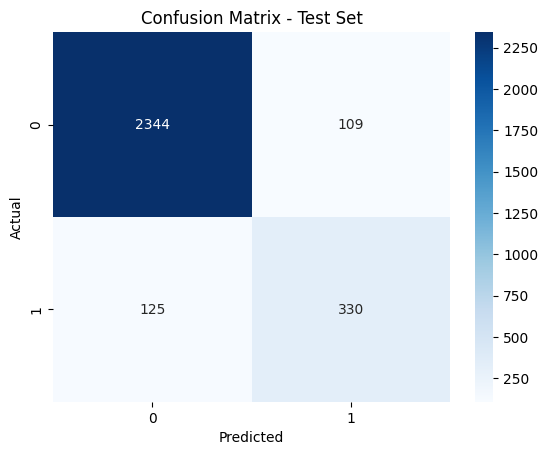

In [42]:
# Assuming class_dict is a dictionary with class names as keys
class_dict = {0: 'No Pain', 1: 'Pain'}
class_names = list(class_dict.keys())

cf_matrix = cf.cpu().numpy()
# Create the heatmap with class names
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

## Correlation of pain with emotion

In [129]:
label_df_original = label_df.copy()

In [130]:
label_df_original.shape

(48398, 6)

In [131]:
from torchvision.models import ResNet18_Weights
from tqdm import tqdm
import os

In [132]:
class PainEmotionDataset(Dataset):
    def __init__(self, label_df, root_dir, transform=None):
        self.annotations = label_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {
            'angry': 0,
            'sad': 1,
            'disgusted': 2,
            'contemptuous': 3,
            'surprised': 4,
            'happy': 5,
            'neutral': 6,
            'fearful': 7
        }

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
    
        if self.transform:
            image = self.transform(image)
        
        return image


# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [133]:
torch.use_deterministic_algorithms(True)
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [134]:
dataset = PainEmotionDataset(label_df=label_df, root_dir='.', transform=transform)
pain_data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [135]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=8):
        super(CNNModel, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [136]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [137]:
num_classes = 8

In [138]:
model = CNNModel(num_classes=num_classes).to(device)
best_model = CNNModel(num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load('best_model_emotion_resnet.pt'))

/var/folders/jg/sz0fr37166zb_s69987d9z280000gn/T/ipykernel_66051/753858750.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_mo

<All keys matched successfully>

In [139]:
class_dict = {
            'angry': 0,
            'sad': 1,
            'disgusted': 2,
            'contemptuous': 3,
            'surprised': 4,
            'happy': 5,
            'neutral': 6,
            'fearful': 7
        }

class_names = list(class_dict.keys())

In [140]:
best_model.eval()
prediction_prob_list = []
prediction_class_list = []

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the pain data loader
    for images_batch in tqdm(pain_data_loader):
        # Move the images batch to the device
        images_batch = images_batch.to(device)
        
        # Forward pass through the model
        output = best_model(images_batch).squeeze()
        
        # Calculate the prediction probabilities and classes
        prediction = torch.softmax(output, dim=1).cpu().numpy()
        predicton_prob = np.max(prediction, axis=1)
        prediction_class_no = np.argmax(prediction, axis=1)
        predict_class = [class_names[p] for p in prediction_class_no]
        
        # Append the prediction probabilities and classes to the respective lists
        prediction_prob_list.extend(predicton_prob)
        prediction_class_list.extend(predict_class)

100%|██████████| 1513/1513 [04:02<00:00,  6.23it/s]


In [151]:
label_df_original['predicted_emotion'] = prediction_class_list
label_df_original['emotion_probability'] = prediction_prob_list

In [152]:
label_df_original['predicted_emotion'].value_counts()

predicted_emotion
happy           20245
angry           15479
fearful          4234
sad              2966
surprised        2156
disgusted        1900
contemptuous     1414
neutral             4
Name: count, dtype: int64

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

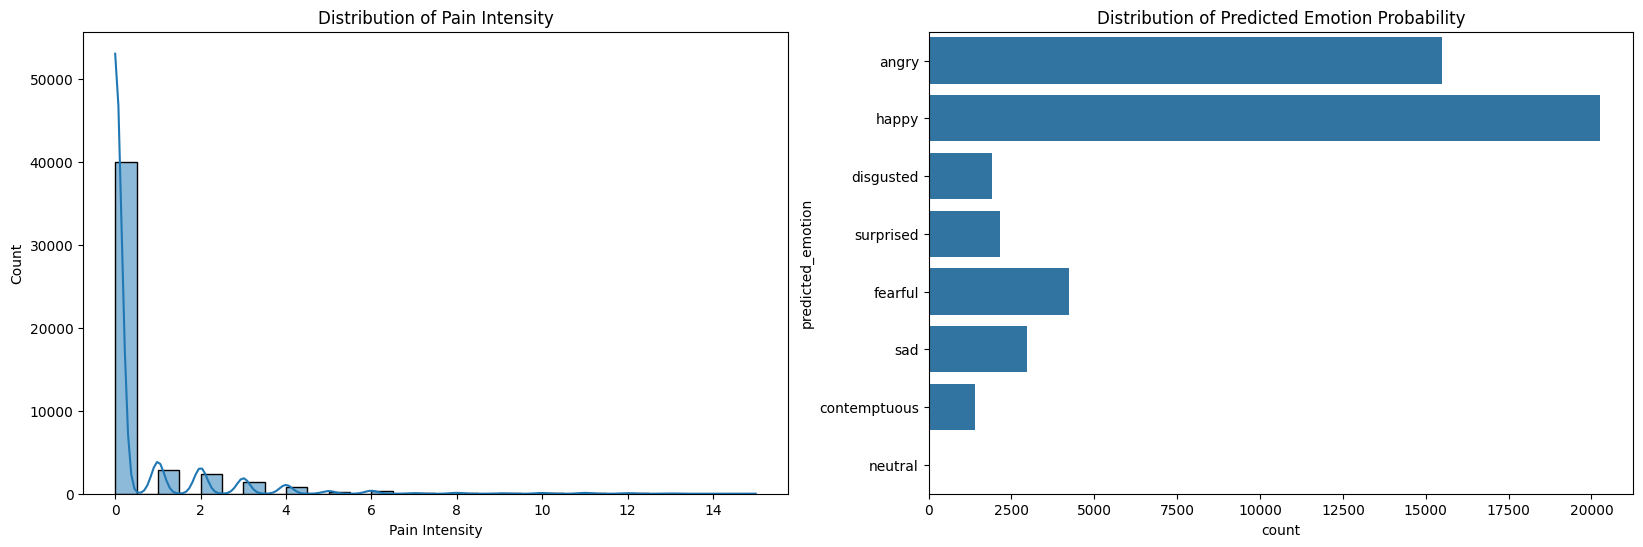

In [154]:
# Analyzing the distribution of Pain Intensity and Predicted Emotion
plt.figure(figsize=(20, 6))

# Distribution of Pain Intensity
plt.subplot(1, 2, 1)
sns.histplot(label_df_original['Pain Intensity'], bins=30, kde=True)
plt.title('Distribution of Pain Intensity')

# Distribution of Predicted Emotion Probability
plt.subplot(1, 2, 2)
sns.countplot(label_df_original['predicted_emotion'])
plt.title('Distribution of Predicted Emotion Probability')

plt.show()

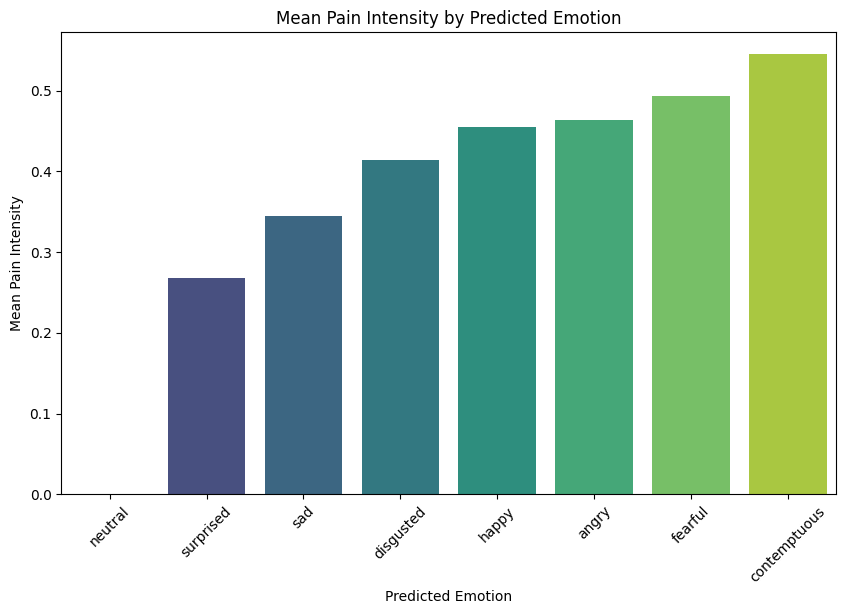

In [155]:
emotion_pain_means = label_df_original.groupby('predicted_emotion')['Pain Intensity'].mean().sort_values()

# Plot the mean pain intensity for each predicted emotion
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_pain_means.index, y=emotion_pain_means.values, palette="viridis", hue=emotion_pain_means.index)
plt.title('Mean Pain Intensity by Predicted Emotion')
plt.xlabel('Predicted Emotion')
plt.ylabel('Mean Pain Intensity')
plt.xticks(rotation=45)
plt.show()

/var/folders/jg/sz0fr37166zb_s69987d9z280000gn/T/ipykernel_66051/461321582.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = label_df_original.groupby(['PSPI Score', 'predicted_emotion']).size().unstack().fillna(0)


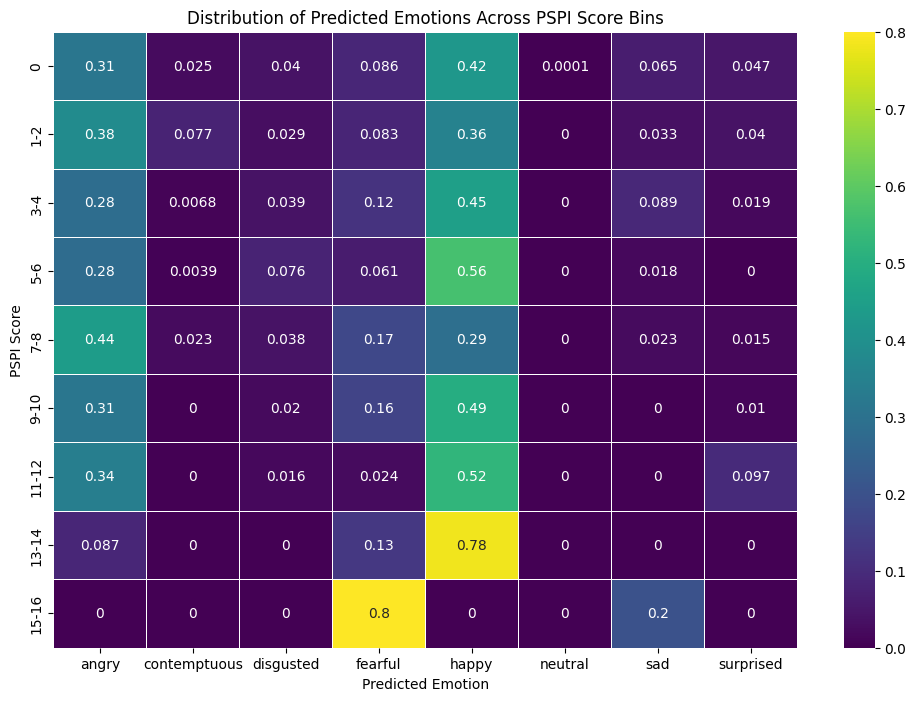

In [156]:
# Define the bins and labels
bins = [-1, 0, 2, 4, 6, 8, 10, 12, 14, 16]
labels = ['0', '1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15-16']

# Categorize the pain intensity into bins
label_df_original['PSPI Score'] = pd.cut(label_df_original['Pain Intensity'], bins=bins, labels=labels)

# Group the data by the new PSPI Score categories and predicted emotion
grouped_data = label_df_original.groupby(['PSPI Score', 'predicted_emotion']).size().unstack().fillna(0)

# Normalize the grouped data for better visualization
grouped_data_normalized = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Plot the normalized grouped data
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data_normalized, annot=True, cmap="viridis", linewidths=.5)
plt.title('Distribution of Predicted Emotions Across PSPI Score Bins')
plt.xlabel('Predicted Emotion')
plt.ylabel('PSPI Score')
plt.show()


In [157]:
grouped_data

predicted_emotion,angry,contemptuous,disgusted,fearful,happy,neutral,sad,surprised
PSPI Score,,,,,,,,
0,12560,989,1615,3456,16929,4,2584,1892
1-2,2019,405,150,437,1868,0,173,208
3-4,624,15,87,261,990,0,196,41
5-6,143,2,39,31,288,0,9,0
7-8,58,3,5,23,38,0,3,2
9-10,31,0,2,16,49,0,0,1
11-12,42,0,2,3,65,0,0,12
13-14,2,0,0,3,18,0,0,0
15-16,0,0,0,4,0,0,1,0


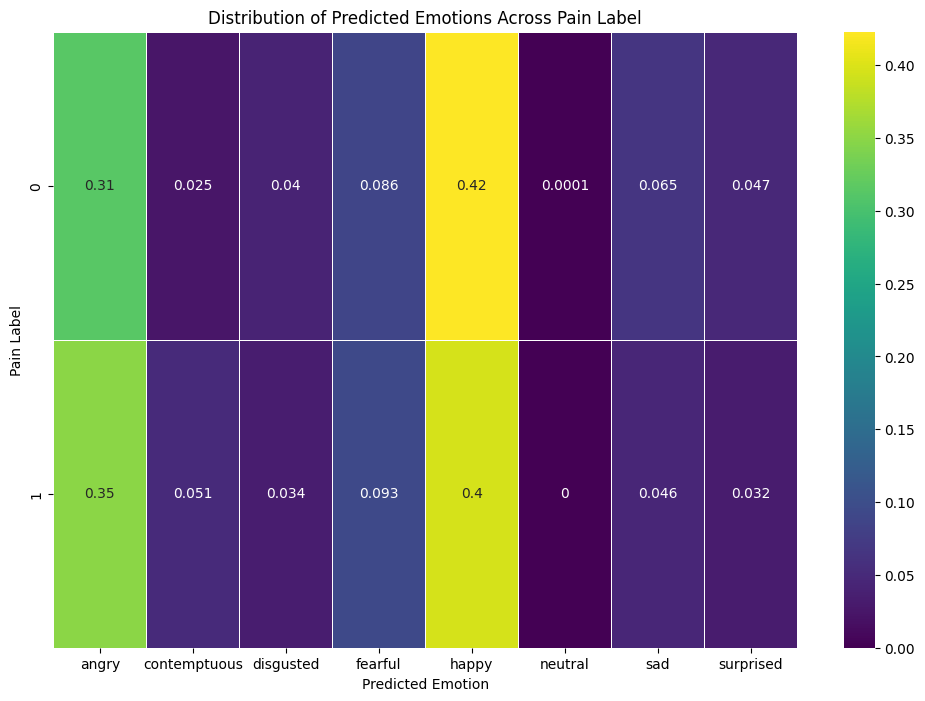

In [158]:
# Group the data by the new PSPI Score categories and predicted emotion
grouped_data = label_df_original.groupby(['Pain Label', 'predicted_emotion']).size().unstack().fillna(0)

# Normalize the grouped data for better visualization
grouped_data_normalized = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Plot the normalized grouped data
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data_normalized, annot=True, cmap="viridis", linewidths=.5)
plt.title('Distribution of Predicted Emotions Across Pain Label')
plt.xlabel('Predicted Emotion')
plt.ylabel('Pain Label')
plt.show()


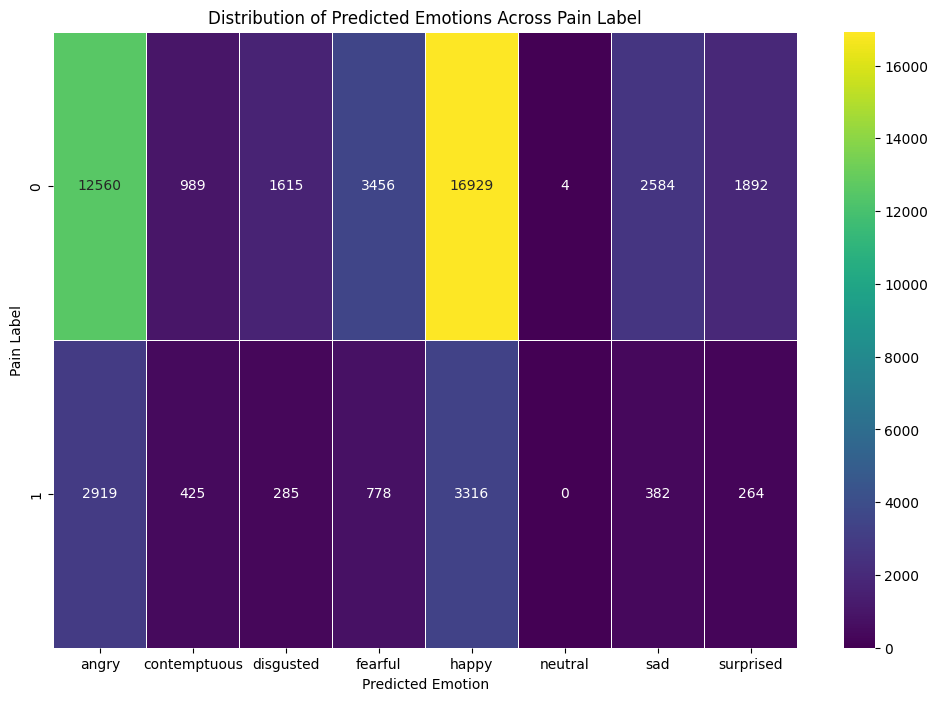

In [159]:
# visusalize grouped data
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, cmap="viridis", linewidths=.5, fmt = '.0f')
plt.title('Distribution of Predicted Emotions Across Pain Label')
plt.xlabel('Predicted Emotion')
plt.ylabel('Pain Label')
plt.show()

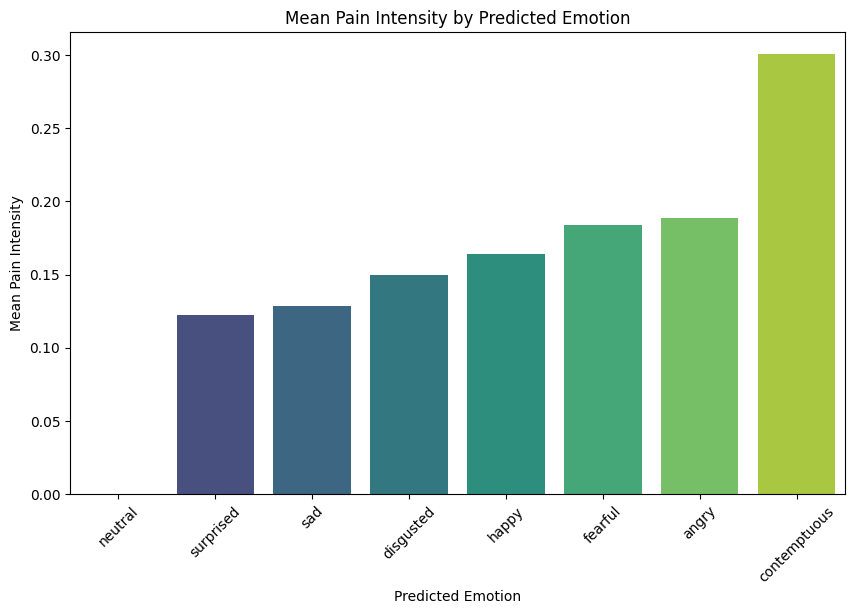

In [160]:
emotion_pain_means = label_df_original.groupby('predicted_emotion')['Pain Label'].mean().sort_values()

# Plot the mean pain intensity for each predicted emotion
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_pain_means.index, y=emotion_pain_means.values, palette="viridis", hue=emotion_pain_means.index)
plt.title('Mean Pain Intensity by Predicted Emotion')
plt.xlabel('Predicted Emotion')
plt.ylabel('Mean Pain Intensity')
plt.xticks(rotation=45)
plt.show()